In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib
import matplotlib.pyplot as plt
print("matplotlib version: {}". format(matplotlib.__version__))

import sklearn # machine learning algorithms
print("scikit-learn version: {}". format(sklearn.__version__))
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV 
from sklearn.ensemble import RandomForestClassifier

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

matplotlib version: 3.4.1
scikit-learn version: 0.24.1
/kaggle/input/tabular-playground-series-may-2021/sample_submission.csv
/kaggle/input/tabular-playground-series-may-2021/train.csv
/kaggle/input/tabular-playground-series-may-2021/test.csv


In [2]:
df_train = pd.read_csv('../input/tabular-playground-series-may-2021/train.csv')
df_test = pd.read_csv('../input/tabular-playground-series-may-2021/test.csv')
sample_submission = pd.read_csv('../input/tabular-playground-series-may-2021/sample_submission.csv') #the sample submission predicts everybody survived
df_all = df_train.append(df_test, ignore_index = True) # created because sometimes it is convenient to work on train and test set together

In [3]:
# drop duplicates
# do any encoding here
# label encode the target column
le = LabelEncoder()
df_train.target = le.fit_transform(df_train.target)
#list(le.classes_) # check the classes that were encoded
#le.inverse_transform(df_train.target) # to transform back

#df_train = pd.get_dummies(df_train, columns= ["target"])

In [4]:
df_train.head()

,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,target
0,0,0,0,1,0,1,0,0,0,0,...,0,0,21,0,0,0,0,0,0,1
1,1,0,0,0,0,2,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,13,2,0,0
3,3,0,0,0,0,0,0,0,3,0,...,0,0,0,0,0,0,0,1,0,3
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1


In [5]:
features = df_train.columns[1:51]
df_train[features].head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49
0,0,0,1,0,1,0,0,0,0,0,...,3,0,0,21,0,0,0,0,0,0
1,0,0,0,0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,2,...,0,0,1,0,0,0,0,13,2,0
3,0,0,0,0,0,0,0,3,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [6]:
df_test.head()
X_test=df_test.drop(columns="id")
X_test.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49
0,0,0,0,0,0,0,4,4,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,2,0,7,7,...,3,0,1,0,0,0,1,0,2,1
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,6,0
3,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,6,9,14,3
4,0,0,0,0,0,0,1,0,4,0,...,1,0,0,0,0,0,0,0,0,0


# Decision Tree
Now it's time to play with my frist model. I will use a simple decision tree first as a baseline and later on Random Forest.

In [7]:
# dividing X, y into train and test data
X_train, X_val, y_train, y_val = train_test_split(df_train[features], df_train.target, random_state = 0, stratify=df_train.target)
# without using stratify the class ratio is still well preserved. I think this is due to the size of the training set. With stratify 
# the class ratio is preserved perfectly

# training a DescisionTreeClassifier
dt = DecisionTreeClassifier(max_depth = 5)
dt.fit(X_train, y_train)
#dt_predictions = dt.predict(X_val) #not really needed, the probablilites are used for the evaluation metric
dt_pred_proba = dt.predict_proba(X_val)
display(dt_pred_proba[0:3])
dt_log_loss_tr = log_loss(y_train,dt.predict_proba(X_train), normalize=True, labels = [0, 1, 2, 3])
dt_log_loss_val = log_loss(y_val,dt_pred_proba, normalize=True, labels = [0, 1, 2, 3])
print("Accuracy on training set:", dt.score(X_train,y_train).round(6))
print("Multiclass Log Loss on training set: ", dt_log_loss_tr.round(6))
print("Accuracy on validation set:", dt.score(X_val,y_val).round(6))
print("Multiclass Log Loss on validation set: ", dt_log_loss_val.round(6))

array([[0.08503237, 0.53932747, 0.23296937, 0.14267079],
       [0.08315245, 0.58258021, 0.20316508, 0.13110225],
       [0.08503237, 0.53932747, 0.23296937, 0.14267079]])

Accuracy on training set: 0.575587
Multiclass Log Loss on training set:  1.110089
Accuracy on validation set: 0.57444
Multiclass Log Loss on validation set:  1.120429


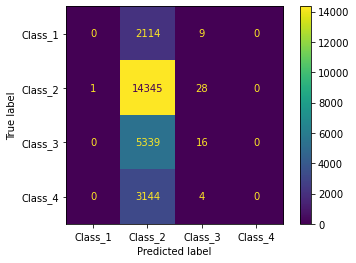

In [8]:
class_labels = ["Class_1","Class_2","Class_3","Class_4"]
plot_confusion_matrix(dt, 
                      X_val, 
                      y_val,
                      values_format='d',
                      display_labels=class_labels)

Accuracy is bad, even on training set. The decision tree classifies nearly everything as the majority class. 

Before tuning the parameters of my estimator, let's check if cross validation is likely to improve the situation. 

In [9]:
# keeping max_depth unchanged, check if cross validation makes a difference
# cross_val_score uses stratifiedKfold to make the splits and compute the score.
# By default the score is Accuracy (the default scorer of the Decision Tree). This can be changed, but I don't know how yet.
cross_val_score(dt,df_train[features], df_train.target, cv=5)

array([0.57455, 0.57515, 0.57435, 0.57485, 0.5749 ])

The cross_val_score is very similar in all folds. This means that cross validation is unlikely to be helpful here. I think the dataset is big enough for holdout validation. 

In [10]:
# for learning purpose...
# this cell represents the LONG version of what is calculated above in cross_val_score. Additionally it outputs the Log Loss per fold.
from sklearn.metrics import accuracy_score
skf = StratifiedKFold(n_splits=5)

def train_model(train, val, fold_no):
    features = df_train.columns[1:51]
    y = ['target']
    X_train = train[features]
    y_train = train[y]
    X_val = val[features]
    y_val = val[y]
    dt.fit(X_train,y_train)
    predictions = dt.predict(X_val)
    pred_proba = dt.predict_proba(X_val)
    print('Fold',str(fold_no),
         ' Accuracy:',
         accuracy_score(y_val,predictions), 
         " Log Loss:",
         log_loss(y_val,pred_proba, normalize=True, labels = [0, 1, 2, 3]))
    
fold_no = 1
for train_index, test_index in skf.split(df_train, df_train.target):
    train = df_train.loc[train_index,:]
    val = df_train.loc[test_index,:]
    print('Fold',str(fold_no),
          'Class Ratio:\n',
          val.target.value_counts(normalize=True)
         )
    train_model(train,val,fold_no) 
    fold_no += 1

Fold 1 Class Ratio:
 1    0.5750
2    0.2142
3    0.1259
0    0.0849
Name: target, dtype: float64
Fold 1  Accuracy: 0.57455  Log Loss: 1.1197138659519017
Fold 2 Class Ratio:
 1    0.5750
2    0.2142
3    0.1259
0    0.0849
Name: target, dtype: float64
Fold 2  Accuracy: 0.57515  Log Loss: 1.1241118112809694
Fold 3 Class Ratio:
 1    0.57495
2    0.21420
3    0.12595
0    0.08490
Name: target, dtype: float64
Fold 3  Accuracy: 0.57435  Log Loss: 1.1162259322736823
Fold 4 Class Ratio:
 1    0.57495
2    0.21420
3    0.12595
0    0.08490
Name: target, dtype: float64
Fold 4  Accuracy: 0.57485  Log Loss: 1.1250180372897276
Fold 5 Class Ratio:
 1    0.57495
2    0.21420
3    0.12595
0    0.08490
Name: target, dtype: float64
Fold 5  Accuracy: 0.5749  Log Loss: 1.123114883885338


Now it's time to see if better hyperparameters lead to a better result or if a decision tree is just a too weak learner for this task. (Spoiler: it is!)

In [11]:
param_grid = {
     'max_depth': [2, 3, 4, 5],
     'min_samples_split': [2, 3, 4],
 }
optimal_params = GridSearchCV(
     estimator=DecisionTreeClassifier(),
     param_grid=param_grid,
     scoring='neg_log_loss', ## see https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
     verbose=2, # NOTE: If you want to see what Grid Search is doing, set verbose=2
     cv = 5,
     return_train_score= True
 )

In [12]:
optimal_params.fit(df_train[features],df_train.target)
print(optimal_params.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ...................max_depth=2, min_samples_split=2; total time=   0.1s
[CV] END ...................max_depth=2, min_samples_split=2; total time=   0.1s
[CV] END ...................max_depth=2, min_samples_split=2; total time=   0.1s
[CV] END ...................max_depth=2, min_samples_split=2; total time=   0.1s
[CV] END ...................max_depth=2, min_samples_split=2; total time=   0.1s
[CV] END ...................max_depth=2, min_samples_split=3; total time=   0.1s
[CV] END ...................max_depth=2, min_samples_split=3; total time=   0.1s
[CV] END ...................max_depth=2, min_samples_split=3; total time=   0.1s
[CV] END ...................max_depth=2, min_samples_split=3; total time=   0.1s
[CV] END ...................max_depth=2, min_samples_split=3; total time=   0.1s
[CV] END ...................max_depth=2, min_samples_split=4; total time=   0.1s
[CV] END ...................max_depth=2, min_sam

In [13]:
display(optimal_params.best_score_)
display(optimal_params.cv_results_['split0_train_score']) # log loss for all 12 combinations with the 1st of 5 splits on training set
optimal_params.cv_results_['split0_test_score']# log loss for all 12 combinations with the 1st of 5 splits on testing set

-1.1146814531036864

array([-1.11481923, -1.11481923, -1.11481923, -1.1133686 , -1.1133686 ,
       -1.1133686 , -1.11176345, -1.11176345, -1.11176345, -1.10975456,
       -1.10975456, -1.10975456])

array([-1.11681685, -1.11681685, -1.11681685, -1.11569878, -1.11569878,
       -1.11569878, -1.11521279, -1.11521279, -1.11521279, -1.11971387,
       -1.11971387, -1.11971387])

In [14]:
optimal_params.cv_results_

{'mean_fit_time': array([0.12762551, 0.1254353 , 0.12511458, 0.18396282, 0.17998457,
        0.1745892 , 0.23315172, 0.23147869, 0.23335409, 0.28990436,
        0.29095654, 0.2951232 ]),
 'std_fit_time': array([0.00340497, 0.00326613, 0.00142568, 0.00628774, 0.0043878 ,
        0.00062037, 0.00325539, 0.00169316, 0.00313175, 0.00229551,
        0.00289497, 0.0074836 ]),
 'mean_score_time': array([0.01312251, 0.01284242, 0.01293616, 0.0140595 , 0.01400995,
        0.01298757, 0.01347003, 0.01322293, 0.01327848, 0.01341348,
        0.01373124, 0.01339607]),
 'std_score_time': array([3.12309461e-04, 1.56950210e-04, 1.73178197e-04, 1.09389746e-03,
        1.76187447e-03, 1.40599008e-04, 1.93266789e-04, 2.14519281e-04,
        9.89464105e-05, 4.89972861e-05, 6.63795056e-04, 1.12212195e-04]),
 'param_max_depth': masked_array(data=[2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False],
 

In [15]:
# retrain
dt = DecisionTreeClassifier(max_depth = 3, min_samples_split=2)
dt.fit(df_train[features],df_train.target)
# predict
predictions = dt.predict_proba(X_test)
predictions[0:4]

array([[0.0862783 , 0.606709  , 0.1929873 , 0.1140254 ],
       [0.08673469, 0.61054422, 0.21598639, 0.08673469],
       [0.08416828, 0.57325009, 0.21010019, 0.13248143],
       [0.08416828, 0.57325009, 0.21010019, 0.13248143]])

In [16]:
# create submission file
sample_submission.drop(columns=class_labels, inplace=True)
submission = (sample_submission.join(pd.DataFrame(data=predictions, columns=class_labels)))
submission.to_csv("submission_DT.csv", index=False)

In [17]:
submission

,id,Class_1,Class_2,Class_3,Class_4
0,100000,0.086278,0.606709,0.192987,0.114025
1,100001,0.086735,0.610544,0.215986,0.086735
2,100002,0.084168,0.573250,0.210100,0.132481
3,100003,0.084168,0.573250,0.210100,0.132481
4,100004,0.085857,0.642656,0.163062,0.108426
...,...,...,...,...,...
49995,149995,0.084168,0.573250,0.210100,0.132481
49996,149996,0.085857,0.642656,0.163062,0.108426
49997,149997,0.084168,0.573250,0.210100,0.132481
49998,149998,0.084168,0.573250,0.210100,0.132481


# Random Forest

I use a Random Forest Classifier here with bootstrapping, i.e. only max_samples of the rows are used for each base estimator. The default setting for max_features ("auto") is unchanged, meaning that max_features=sqrt(n_features) are used in each base estimator. 

Then I experiment with **Cost Sensitive Learning** (i.e. changing the parameter class_weight, guided by [this tutorial](https://machinelearningmastery.com/bagging-and-random-forest-for-imbalanced-classification/)): 
- default value "None"
- "balanced" - adjust weights inversely proportional to class frequencies in the input data
- "balanced_subsample" - same as “balanced” except that weights are computed based on the bootstrap sample for every tree grown
- different weights specified manually

Unfortunatelly my attempts were not fruitful. So I will fall back on the default value for class_weight.

In [18]:
forest = RandomForestClassifier(criterion="gini", max_depth=5, min_samples_leaf = 2, random_state=0, max_samples = 0.8, class_weight={0:4, 1:1, 2:2, 3:3})
forest.fit(X_train,y_train)
print("Training accuracy: ", forest.score(X_train,y_train).round(6))
print("Validation accuracy: ", forest.score(X_val,y_val).round(6))
# class_weigth = "None"
# Training accuracy:  0.575027
# Validation accuracy:  0.57496
# class_weight = "balanced"
# Training accuracy:  0.324933
# Validation accuracy:  0.31292 # hm, why is it worse? too much weight on the minority classes?
# class_weight = "balanced_subsample"
# Training accuracy:  0.319693
# Validation accuracy:  0.30808 
# class_weight = {0:2, 1:1, 2:2, 3:2}
# Training accuracy:  0.576893
# Validation accuracy:  0.57448
# class_weight = {0:4, 1:1, 2:2, 3:3}
# Training accuracy:  0.57712
# Validation accuracy:  0.57468

Training accuracy:  0.57712
Validation accuracy:  0.57468


In [19]:
forest_pred_proba_tr = forest.predict_proba(X_train)
forest_log_loss_tr = log_loss(y_train,forest_pred_proba_tr, normalize=True, labels = [0, 1, 2, 3])
forest_pred_proba_val = forest.predict_proba(X_val)
forest_log_loss_val = log_loss(y_val,forest_pred_proba_val, normalize=True, labels = [0, 1, 2, 3])
print("Multiclass Log Loss on training set: ", forest_log_loss_tr.round(6))
print("Multiclass Log Loss on validation set: ", forest_log_loss_val.round(6))

# class_weigth = "None"
# Multiclass Log Loss on training set:  1.107705
# Multiclass Log Loss on validation set:  1.110149
# class_weight = "balanced"
# Multiclass Log Loss on training set:  1.374009
# Multiclass Log Loss on validation set:  1.376436
# class_weight = "balanced_subsample"
# Multiclass Log Loss on training set:  1.374477
# Multiclass Log Loss on validation set:  1.376888
# class_weight = {0:2, 1:1, 2:2, 3:2}
# Multiclass Log Loss on training set:  1.166128
# Multiclass Log Loss on validation set:  1.168808
# class_weight = {0:4, 1:1, 2:2, 3:3}
# Multiclass Log Loss on training set:  1.24449
# Multiclass Log Loss on validation set:  1.247212

Multiclass Log Loss on training set:  1.24449
Multiclass Log Loss on validation set:  1.247212


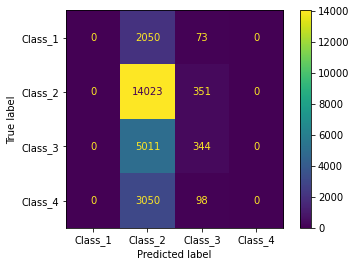

In [20]:
plot_confusion_matrix(forest, 
                      X_val, 
                      y_val,
                      values_format='d',
                      display_labels=class_labels)

This looks worse than the plain and simple Decision Tree, only Class_2 is predicted. Using class_weight "balanced" or "balanced_subsample" makes a huge difference. Now all Classes are predicted, but much more evenly than they should be predicted. So the overall result is worse. 

In [21]:
# do Grid Search
# Round 1
#param_grid = {
#     'n_estimators' : [100, 150, 200],
#     'max_depth': [3, 4, 5],
#     'min_samples_leaf': [3, 4, 5],
# }
param_grid = {
     'n_estimators' : [150, 200, 250],
     'max_depth': [4, 5, 6],
     'min_samples_leaf': [4, 5, 6]
 }
optimal_params = GridSearchCV(
     estimator=RandomForestClassifier(max_samples = 0.8),
     param_grid=param_grid,
     scoring='neg_log_loss', ## see https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
     verbose=2, # NOTE: If you want to see what Grid Search is doing, set verbose=2
     cv = 3,
     return_train_score= False
 )
# Round 1: {'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 200}
# Round 2: {'max_depth': 6, 'min_samples_leaf': 6, 'n_estimators': 250} 

In [22]:
#optimal_params.fit(df_train[features],df_train.target)
#print(optimal_params.best_params_)

In [23]:
# just play around with n_estimators
forest = RandomForestClassifier(n_estimators = 300, max_depth=6, min_samples_leaf = 6, random_state=0, max_samples = 0.8)
forest.fit(X_train,y_train)
print("Training accuracy: ", forest.score(X_train,y_train).round(6))
print("Validation accuracy: ", forest.score(X_val,y_val).round(6))
# predict
forest_pred_proba_tr = forest.predict_proba(X_train)
forest_log_loss_tr = log_loss(y_train,forest_pred_proba_tr, normalize=True, labels = [0, 1, 2, 3])
forest_pred_proba_val = forest.predict_proba(X_val)
forest_log_loss_val = log_loss(y_val,forest_pred_proba_val, normalize=True, labels = [0, 1, 2, 3])
print("Multiclass Log Loss on training set: ", forest_log_loss_tr.round(6))
print("Multiclass Log Loss on validation set: ", forest_log_loss_val.round(6))
# n_estimators = 300
#Training accuracy:  0.57504
#Validation accuracy:  0.57504
#Multiclass Log Loss on training set:  1.10489
#Multiclass Log Loss on validation set:  1.108934
# n_estimators = 400
#Training accuracy:  0.575
#Validation accuracy:  0.57496
#Multiclass Log Loss on training set:  1.104849
#Multiclass Log Loss on validation set:  1.108959

Training accuracy:  0.57504
Validation accuracy:  0.57504
Multiclass Log Loss on training set:  1.10489
Multiclass Log Loss on validation set:  1.108934


In [24]:
# retrain with better hyperparameters
forest = RandomForestClassifier(n_estimators = 300, max_depth=6, min_samples_leaf = 6, random_state=0, max_samples = 0.8)
forest.fit(df_train[features],df_train.target)

RandomForestClassifier(max_depth=6, max_samples=0.8, min_samples_leaf=6,
                       n_estimators=300, random_state=0)

In [25]:
predictions = forest.predict_proba(X_test)

In [26]:
# create submission file
#sample_submission.drop(columns=class_labels, inplace=True)
submission = (sample_submission.join(pd.DataFrame(data=predictions, columns=class_labels)))
submission.to_csv("submission_RF.csv", index=False)
submission

,id,Class_1,Class_2,Class_3,Class_4
0,100000,0.087748,0.599585,0.195956,0.116711
1,100001,0.083597,0.580105,0.229770,0.106528
2,100002,0.085209,0.576615,0.212060,0.126116
3,100003,0.084991,0.567278,0.211228,0.136503
4,100004,0.083513,0.605310,0.193417,0.117760
...,...,...,...,...,...
49995,149995,0.085882,0.624562,0.177874,0.111682
49996,149996,0.085040,0.614100,0.180632,0.120228
49997,149997,0.084758,0.557359,0.221592,0.136291
49998,149998,0.082596,0.561444,0.217922,0.138038


# Understanding Mulitclass Log Loss

In [27]:
from sklearn.metrics import log_loss
proba = [[0.1, 0.6, 0.1, 0.2],[0.1, 0.4, 0.2, 0.3]]
gt = [[0,1,0,0], [0,0,1,0]]
log_loss(gt,proba, normalize=True)

1.0601317681000455

In [28]:
proba = [[0.1, 0.6, 0.1, 0.2],[0.1, 0.4, 0.2, 0.3]]
gt = [[1], [2]]
log_loss(gt,proba, normalize=True, labels = [0, 1, 2, 3])

1.0601317681000455

In [29]:
proba = [[0.1, 0.6, 0.1, 0.2]]
gt = [[0,1,0,0]]
display(log_loss(gt,proba, normalize=True))
-np.log(0.6)

0.5108256237659907

0.5108256237659907

In [30]:
proba = [[0.1, 0.4, 0.2, 0.3]]
gt = [[0,0,1,0]]
display(log_loss(gt,proba, normalize=True))
-np.log(0.2)

1.6094379124341003

1.6094379124341003

In [31]:
proba = [[0.1, 0.6, 0.1, 0.2],[0.1, 0.4, 0.2, 0.3]]
gt = [[0,1,0,0], [0,0,1,0]]
display(log_loss(gt,proba, normalize=True))
(np.log(0.6) + np.log(0.2)) / -2

1.0601317681000455

1.0601317681000455

In [32]:
#proba = [[10**-15, 10**-15, 1-(10**-15), 10**-15]]

proba = [[0,0,1,0]]
gt = [[0,0,1,0]]
display(log_loss(gt,proba, normalize=True))
-np.log(1-(10**-15))

# is the result close enough? both is basically zero

3.219646771412959e-15

9.992007221626415e-16

In [33]:
10**-15


1e-15